In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,Subset

import numpy as np
import matplotlib.pyplot as plt

from torchvision import transforms
from torchvision.utils import make_grid,save_image

import os
from PIL import Image
from tqdm import tqdm
from IPython.display import clear_output


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [ ]:
config = {
'DEVICE' : "cuda" if torch.cuda.is_available() else "cpu",
#'PATH' :'/kaggle/input/cyberpunk/cyber/cyberpunk',
'PATH' :'/content/drive/MyDrive/Colab_Notebooks/projects/Pix2Pix_GAN/cyber/cyberpunk',
'LEARNING_RATE' : 2e-4,
'BATCH_SIZE' : 16,
'NUM_WORKERS' : 2,
'IMAGE_SIZE' : 256,
'CHANNELS_IMG' : 3,
'L1_LAMBDA' : 100,
'LAMBDA_GP' : 10,
'NUM_EPOCHS' : 100,
'LOAD_MODEL' : False,
'SAVE_MODEL' : True,
'SHOW_EVERY': 5,
#'WEIGHTS_FOLDER': '/kaggle/working/weights',
#'SAMPLES_FOLDER' : '/kaggle/working/samples_folder'
'WEIGHTS_FOLDER': '/content/drive/MyDrive/Colab_Notebooks/projects/Pix2Pix_GAN/weights',
'SAMPLES_FOLDER' : '/content/drive/MyDrive/Colab_Notebooks/projects/Pix2Pix_GAN/samples_folder'


          }

In [ ]:
# Преобразования для цветного изображения
transform = transforms.Compose([
    transforms.Resize((config['IMAGE_SIZE'], config['IMAGE_SIZE'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Преобразования для черно-белого изображения
transform_bw = transforms.Compose([
    transforms.Resize((config['IMAGE_SIZE'], config['IMAGE_SIZE'])),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, img_path, transform=None):
        self.img_path = img_path
        self.transform = transform
        self.file_list = os.listdir(img_path)
        self.filtered_files = self.filter_image_files()


    def filter_image_files(self):
        # Фильтрация изображений с неправильным режимом (количество каналов)
        filtered_files = []
        for image_file in self.file_list:
            img_path = os.path.join(self.img_path, image_file)
            image = Image.open(img_path)
            if image.mode == 'RGB':
                filtered_files.append(image_file)

        return filtered_files

    def __len__(self):
        return len(self.filter_image_files())

    def __getitem__(self, index):
        filename = self.filtered_files[index]
        img_path = os.path.join(self.img_path, filename)

        img = Image.open(img_path)#.convert('RGB')
        if self.transform is not None:
            img = self.transform(img)

        return img

In [ ]:
dataset = CustomDataset(config['PATH'], transform=transform)
train_indices = list(range(len(dataset)))[:2500]
val_indices = list(range(len(dataset)))[2500:]

In [ ]:
 len(dataset)

8200

In [ ]:
print(config['DEVICE'])

cuda


In [ ]:
train_dataset_c = Subset(dataset, train_indices)
val_dataset_c = Subset(dataset, val_indices)

In [ ]:
dataset_bw = CustomDataset(config['PATH'], transform=transform_bw)

train_dataset_bw = Subset(dataset_bw, train_indices)
val_dataset_bw = Subset(dataset_bw, val_indices)

In [ ]:
class ConcatDatasets(Dataset):
    def __init__(self, *datasets):
        self.datasets = datasets

    def __len__(self):
        return min(len(d) for d in self.datasets)

    def __getitem__(self, i):
        return tuple(d[i] for d in self.datasets)

In [ ]:
train_dataset = ConcatDatasets(train_dataset_bw, train_dataset_c)
val_dataset = ConcatDatasets(val_dataset_bw, val_dataset_c)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

In [ ]:
example_c, example_bw = next(iter(val_loader))

In [ ]:
#функция, чтобы ранее нормализованные изображения отображались корректно
def reverse_normalize(image, mean_=0.5, std_=0.5):
    if torch.is_tensor(image):
        image = image.detach().numpy()
    un_normalized_img = image * std_ + mean_
    un_normalized_img = un_normalized_img * 255
    return np.uint8(un_normalized_img)

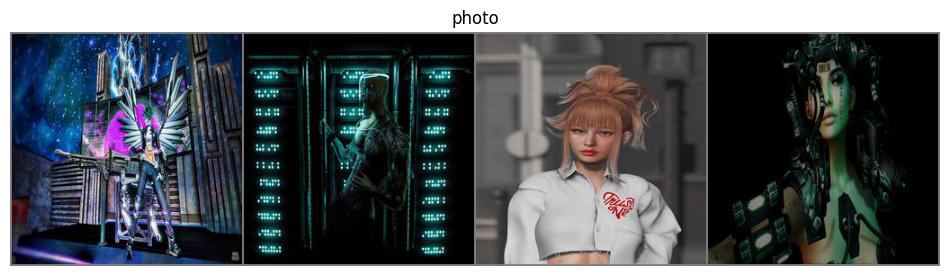

In [ ]:
#Проверка трансформаций исходного датасета
images_normalized  = example_bw
grid_normalized = make_grid(images_normalized, nrow=4).permute(1, 2, 0).detach().numpy()
grid_original = reverse_normalize(grid_normalized)
fig = plt.figure(figsize=(12, 5))
plt.imshow(grid_original)
plt.axis('off')
plt.title('photo')
plt.show()

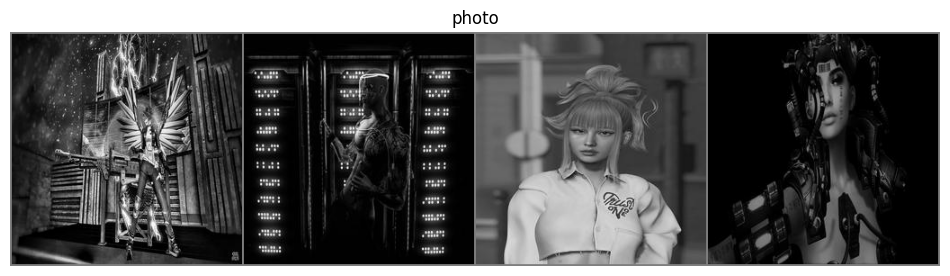

In [ ]:
#Проверка результата трансформации в чб
images_normalized  = example_c
grid_normalized = make_grid(images_normalized, nrow=4).permute(1, 2, 0).detach().numpy()
grid_original = reverse_normalize(grid_normalized)
fig = plt.figure(figsize=(12, 5))
plt.imshow(grid_original)
plt.axis('off')
plt.title('photo')
plt.show()

In [ ]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(CNNBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, 4, stride, 1, bias=False, padding_mode="reflect"
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.conv(x)


class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(
                in_channels * 2,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
            ),
            nn.LeakyReLU(0.2),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                CNNBlock(in_channels, feature, stride=1 if feature == features[-1] else 2),
            )
            in_channels = feature

        layers.append(
            nn.Conv2d(
                in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"
            ),
        )

        self.model = nn.Sequential(*layers)

    def forward(self, x, y):
        x = torch.cat([x, y], dim=1)
        x = self.initial(x)
        x = self.model(x)
        return x


def test():
    x = torch.randn((1, 3, 256, 256))
    y = torch.randn((1, 3, 256, 256))
    model = Discriminator(in_channels=3)
    preds = model(x, y)
    print(model)
    print(preds.shape)

In [ ]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act="relu", use_dropout=False):
        super(Block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False, padding_mode="reflect")
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU() if act == "relu" else nn.LeakyReLU(0.2),
        )

        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
        self.down = down

    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x


class Generator(nn.Module):
    def __init__(self, in_channels=3, features=64):
        super().__init__()
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, features, 4, 2, 1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        )
        self.down1 = Block(features, features * 2, down=True, act="leaky", use_dropout=False)
        self.down2 = Block(
            features * 2, features * 4, down=True, act="leaky", use_dropout=False
        )
        self.down3 = Block(
            features * 4, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down4 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down5 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down6 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features * 8, features * 8, 4, 2, 1), nn.ReLU()
        )

        self.up1 = Block(features * 8, features * 8, down=False, act="relu", use_dropout=True)
        self.up2 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True
        )
        self.up3 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True
        )
        self.up4 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=False
        )
        self.up5 = Block(
            features * 8 * 2, features * 4, down=False, act="relu", use_dropout=False
        )
        self.up6 = Block(
            features * 4 * 2, features * 2, down=False, act="relu", use_dropout=False
        )
        self.up7 = Block(features * 2 * 2, features, down=False, act="relu", use_dropout=False)
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(features * 2, in_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottleneck(d7)
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1, d7], 1))
        up3 = self.up3(torch.cat([up2, d6], 1))
        up4 = self.up4(torch.cat([up3, d5], 1))
        up5 = self.up5(torch.cat([up4, d4], 1))
        up6 = self.up6(torch.cat([up5, d3], 1))
        up7 = self.up7(torch.cat([up6, d2], 1))
        return self.final_up(torch.cat([up7, d1], 1))


def test_generator():
    x = torch.randn((1, 3, 256, 256))
    model = Generator(in_channels=3, features=64)
    preds = model(x)
    print(preds.shape)

In [ ]:
def train(
    disc, gen, loader, opt_disc, opt_gen, l1_loss, bce, g_scaler, d_scaler,
):
    loop = tqdm(loader, leave=True)
    for idx, (x, y) in enumerate(loop):
        x = x.to(config['DEVICE'])  # Перемещение входного изображения на устройство
        y = y.to(config['DEVICE'])  # Перемещение выходного изображения на устройство

        # Обучение дискриминатора
        with torch.cuda.amp.autocast():
            y_fake = gen(x)  # Генерация фейкового выходного изображения с помощью генератора
            D_real = disc(x, y)  # Вычисление выхода дискриминатора на реальных изображениях
            D_real_loss = bce(D_real, torch.ones_like(D_real))  # Вычисление потери дискриминатора на реальных изображениях
            D_fake = disc(x, y_fake.detach())  # Вычисление выхода дискриминатора на фейковых изображениях
            D_fake_loss = bce(D_fake, torch.zeros_like(D_fake))  # Вычисление потери дискриминатора на фейковых изображениях
            D_loss = (D_real_loss + D_fake_loss) / 2  # Вычисление общей потери дискриминатора

        disc.zero_grad()  # Обнуление градиентов дискриминатора
        d_scaler.scale(D_loss).backward()  # Обратное распространение ошибки и масштабирование градиентов для дискриминатора
        d_scaler.step(opt_disc)  # Обновление параметров дискриминатора с оптимизатором
        d_scaler.update()  # Обновление scaler для градиентного масштабирования

        # Обучение генератора
        with torch.cuda.amp.autocast():
            D_fake = disc(x, y_fake)  # Вычисление выхода дискриминатора на фейковых изображениях
            G_fake_loss = bce(D_fake, torch.ones_like(D_fake))  # Вычисление потери генератора на фейковых изображениях
            L1 = l1_loss(y_fake, y) * config['L1_LAMBDA']  # Вычисление L1-потери между фейковыми и истинными изображениями с весом config['L1_LAMBDA']
            G_loss = G_fake_loss + L1  # Вычисление общей потери генератора

        opt_gen.zero_grad()  # Обнуление градиентов генератора
        g_scaler.scale(G_loss).backward()  # Обратное распространение ошибки и масштабирование градиентов для генератора
        g_scaler.step(opt_gen)  # Обновление параметров генератора с оптимизатором
        g_scaler.update()  # Обновление scaler для градиентного масштабирования

        if idx % 10 == 0:
            loop.set_postfix(        #set_postfix() используется для вывода информации о прогрессе обучения в виде строки, которая обновляется на каждой итерации цикла обучения.
                D_real=torch.sigmoid(D_real).mean().item(),  # Среднее значение сигмоиды выхода дискриминатора на реальных изображениях
                D_fake=torch.sigmoid(D_fake).mean().item(),  # Среднее значение сигмоиды выхода дискриминатора на фейковых изображениях
            )

    return G_loss, D_loss  # Возврат потери генератора и дискриминатора

In [ ]:
def visualize_images(generator, val_loader,n_epoch=None):
    print('Get ready to see something...')
    generator.eval()
    for batch_idx, (x, y) in enumerate(val_loader):
        # Generate output image
        output_image = generator(x.to(config['DEVICE']))

        # Convert tensors to numpy arrays
        input_image = x.detach().cpu().numpy()
        output_image = output_image.detach().cpu().numpy()
        target = y.detach().cpu().numpy()

        # Reverse normalize

        input_image = reverse_normalize(input_image)
        output_image = reverse_normalize(output_image)
        target  = reverse_normalize(target)

        # Display images
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(np.transpose(input_image[0], (1, 2, 0)))
        axs[0].set_title(f'Input Image_{n_epoch}')
        axs[0].axis('off')
        axs[1].imshow(np.transpose(output_image[0], (1, 2, 0)))
        axs[1].set_title(f'Generated Image_{n_epoch}')
        axs[1].axis('off')
        axs[2].imshow(np.transpose(target[0], (1, 2, 0)))
        axs[2].set_title(f'Target Image_{n_epoch}')
        axs[2].axis('off')
        plt.show()
        if batch_idx > 3:
            break


In [ ]:
#Функция для сохрания примеров
def save_samples(gen, val_loader, epoch, folder):
    x, y = next(iter(val_loader))
    x, y = x.to(config['DEVICE']), y.to(config['DEVICE'])
    gen.eval()
    with torch.no_grad():
        y_fake = gen(x)
        y_fake = y_fake * 0.5 + 0.5  # remove normalization#
        save_image(y_fake, folder + f"/y_gen_{epoch+1}.jpg")
    gen.train()

In [ ]:
##Функции для сохранения весов моделей
def save_gen(state, path):
    torch.save(state, path)

def save_disc(state, path):
    torch.save(state, path)

In [ ]:
#!cd /kaggle/working/
#!mkdir weights

mkdir: cannot create directory ‘weights’: File exists


In [ ]:
#!mkdir samples_folder

mkdir: cannot create directory ‘samples_folder’: File exists


In [ ]:
disc = Discriminator(in_channels=3).to(config['DEVICE'])
gen = Generator(in_channels=3, features=64).to(config['DEVICE'])

opt_disc = optim.Adam(disc.parameters(), lr=config['LEARNING_RATE'], betas=(0.5, 0.999),)
opt_gen = optim.Adam(gen.parameters(), lr=config['LEARNING_RATE'], betas=(0.5, 0.999))

BCE = nn.BCEWithLogitsLoss()
L1_LOSS = nn.L1Loss()

g_scaler = torch.cuda.amp.GradScaler()  # Создание объекта GradScaler для генератора
d_scaler = torch.cuda.amp.GradScaler()  # Создание объекта GradScaler для дискриминатора


g_losses = []  # Список для сохранения значений функции потерь генератора
d_losses = []  # Список для сохранения значений функции потерь дискриминатора

for epoch in range(config['NUM_EPOCHS']):
    print(f'The {epoch+1} epoch is starting...')
    G_loss, D_loss = train(
        disc, gen, train_loader, opt_disc, opt_gen, L1_LOSS, BCE, g_scaler, d_scaler,
    )

    g_losses.append(G_loss.detach().cpu())  # Сохранение значения функции потерь генератора
    d_losses.append(D_loss.detach().cpu())  # Сохранение значения функции потерь дискриминатора

    print('Discriminator loss {}'.format(D_loss))
    print('Generator loss {}'.format(G_loss))

    BEST_PATH_DISC = config['WEIGHTS_FOLDER'] + f'/Bdisc_{epoch+1}.pth'  # Путь для сохранения лучших весов дискриминатора
    BEST_PATH_GEN = config['WEIGHTS_FOLDER'] + f'/Bgen_{epoch+1}.pth'  # Путь для сохранения лучших весов генератора


    if D_loss.detach().cpu() == min(d_losses):
        save_disc(disc.state_dict(),  BEST_PATH_DISC)  # Сохранение весов дискриминатора
        print('New best discriminator')


    if G_loss.detach().cpu() == min(g_losses):
        save_gen(gen.state_dict(),  BEST_PATH_GEN)  # Сохранение весов генератора
        print('New best generator')

    if (epoch+1) % config['SHOW_EVERY'] == 0:
        #clear_output(wait = True)
        visualize_images(gen, val_loader, epoch+1)
        save_samples(gen, val_loader, epoch, config['SAMPLES_FOLDER'])




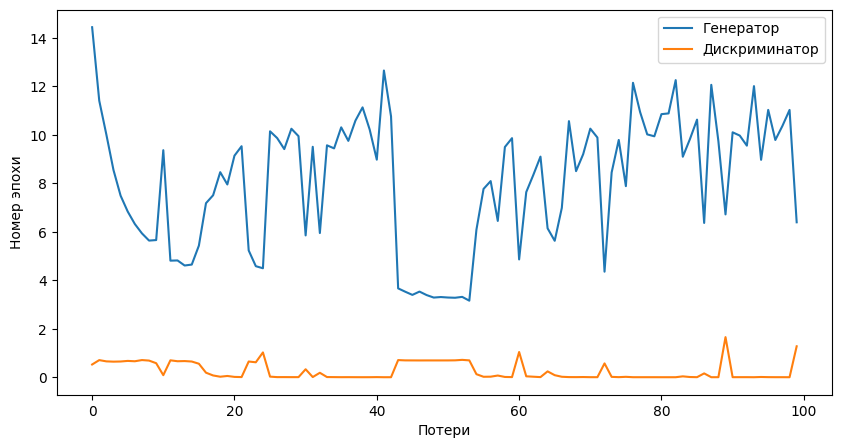

In [ ]:
plt.figure(figsize = (10,5))
epochs = [i for i in range(len(g_losses))]
plt.plot(epochs, g_losses,label='Генератор')
plt.plot(epochs, d_losses,label='Дискриминатор')

plt.xlabel('Потери')
plt.ylabel('Номер эпохи')

plt.legend()

In [ ]:
for i in range(len(g_losses)):
  if g_losses[i] == min(g_losses):
    print(i+1)
    break

54


Лучшее качество было достигнуто на 54 эпохе

In [ ]:
!cd /kaggle/working
!tar -czvf my_work.zip -C

tar: option requires an argument -- 'C'
Try 'tar --help' or 'tar --usage' for more information.


In [ ]:
"""def remove_folder_contents(folder):
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                remove_folder_contents(file_path)
                os.rmdir(file_path)
        except Exception as e:
            print(e)

remove_folder_contents(config['SAMPLES_FOLDER'])
remove_folder_contents(config['WEIGHTS'])
 """

In [ ]:
#save_samples(gen, val_loader, epoch, config['SAMPLES_FOLDER'])

## Загрузка и применение генератора

In [ ]:
#Поскольку результат вышел скорее артовый, возникла идея, чтобы пользователь мог случайным образом раскрашивать свои фото. Создать список с доступными номерами эпох:
import re
ep_list =[]
pattern = r'\d+'
for file in os.listdir(config['WEIGHTS_FOLDER']):
  if file.startswith('Bgen'):
      match = re.search(pattern, file)
      number = int(match.group())
      ep_list.append(number)
print(ep_list)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 14, 24, 25, 44, 45, 46, 48, 49, 52, 54]


In [ ]:
len(ep_list)

20

In [ ]:
#Функции для загрузки весов генератора
def load_gen(path, epoch=54):
    return torch.load(path+f'/Bgen_{epoch}.pth',map_location=torch.device('cpu'))


In [ ]:
#функция, чтобы ранее нормализованные изображения отображались корректно
def reverse_normalize(image, mean_=0.5, std_=0.5):
    if torch.is_tensor(image):
        image = image.detach().numpy()
    un_normalized_img = image * std_ + mean_
    un_normalized_img = un_normalized_img * 255
    return np.uint8(un_normalized_img)

In [ ]:
config['DEVICE']

'cpu'

In [ ]:
gen = Generator(in_channels=3, features=64).to(config['DEVICE'])
generator_weights = load_gen(config['WEIGHTS_FOLDER'], epoch=6)
gen.load_state_dict(generator_weights)

<All keys matched successfully>

In [ ]:
img_path = '/content/drive/MyDrive/Colab_Notebooks/projects/Pix2Pix_GAN/test/DSCF6393 (2).JPG'
img_path='/content/7hlpLFKHzyM.jpg'


(-0.5, 255.5, 255.5, -0.5)

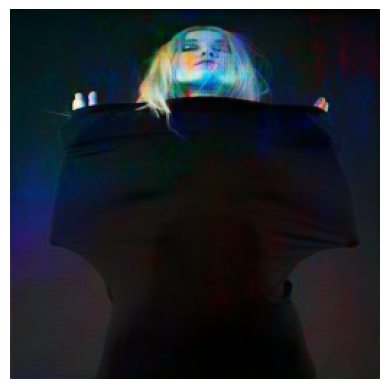

In [ ]:
input_image = Image.open(img_path)
preprocess = transform_bw
input_tensor = preprocess(input_image).unsqueeze(0)
gen.to('cpu')
with torch.no_grad():
   output_tensor  = gen(input_tensor)
output_tensor = output_tensor.squeeze()
output_image = reverse_normalize(output_tensor.permute(1, 2, 0).detach().numpy())
plt.imshow(output_image)
plt.axis('off')

In [ ]:
img_path='/content/_DSC121211.jpg'


In [ ]:
def making_multiplot(path):
  input_image = Image.open(path)
  preprocess = transform_bw
  input_tensor = preprocess(input_image).unsqueeze(0)
  fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(10, 8))
  axes = axes.flatten()

  for i in range(20):
      ep = ep_list[i]
      generator_weights = load_gen(config['WEIGHTS_FOLDER'], epoch=ep)
      gen.load_state_dict(generator_weights)
      gen.to('cpu')

      with torch.no_grad():
          output_tensor = gen(input_tensor)
          output_tensor = output_tensor.squeeze()
          output_image = reverse_normalize(output_tensor.permute(1, 2, 0).detach().numpy())

      axes[i].imshow(output_image)
      axes[i].set_title(f'Image {i+1}')
      axes[i].axis('off')

  plt.tight_layout()
  plt.show()


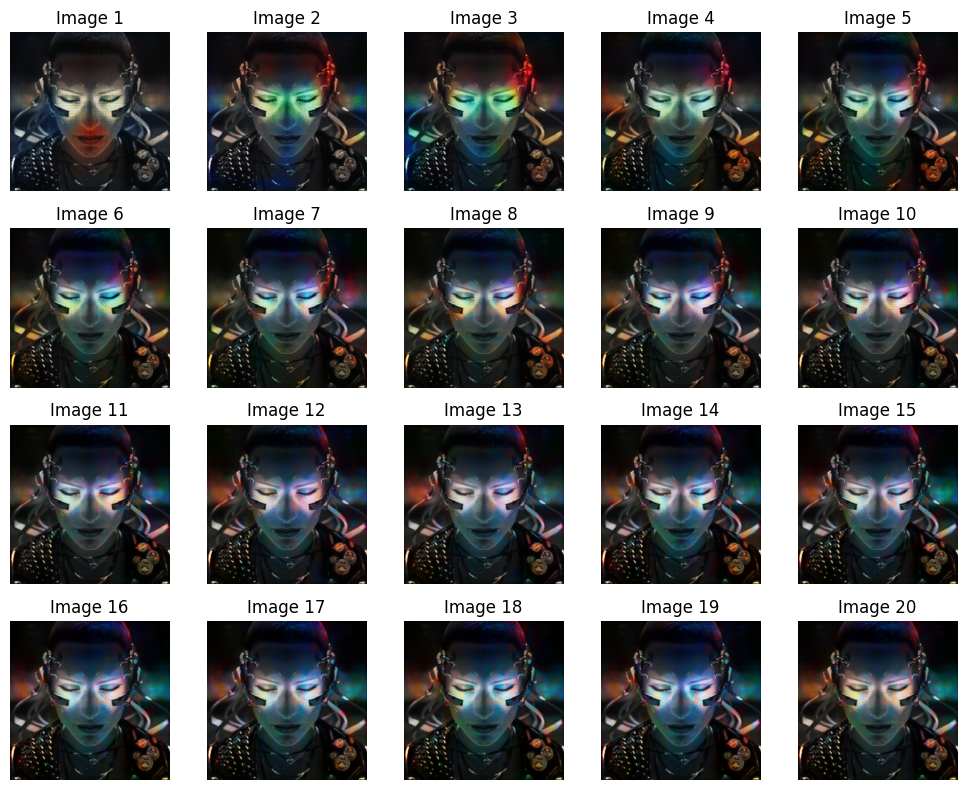

In [ ]:
making_multiplot('/content/cyberpunk_2077.jpg')

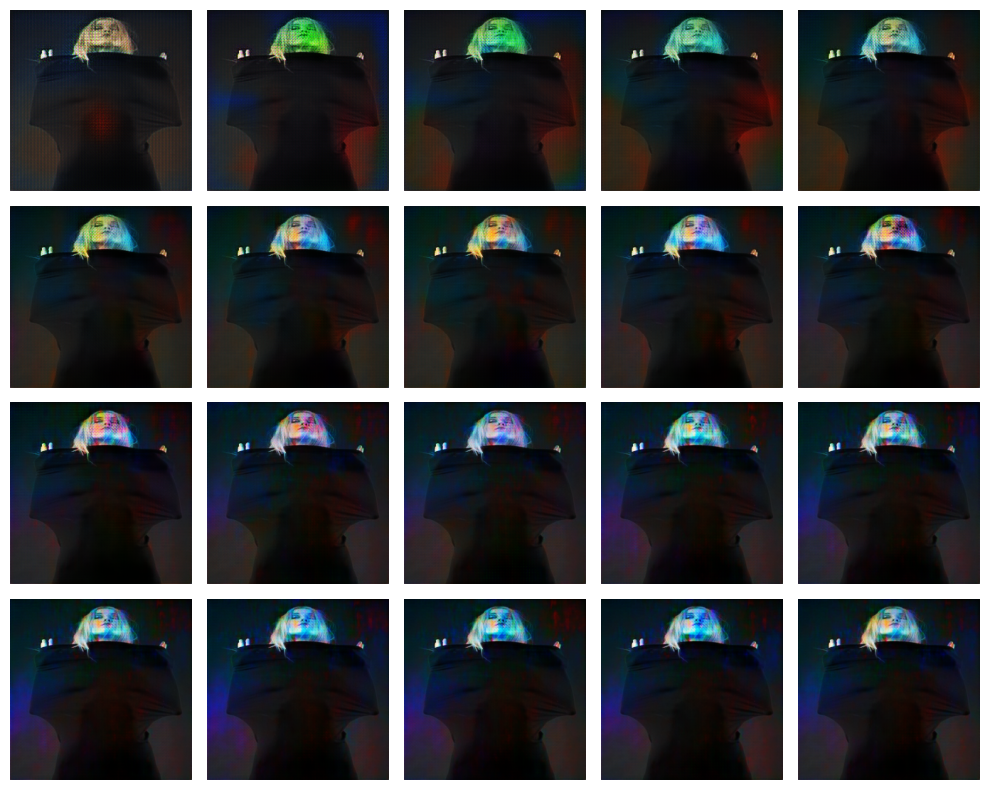

In [ ]:
making_multiplot(img_path)

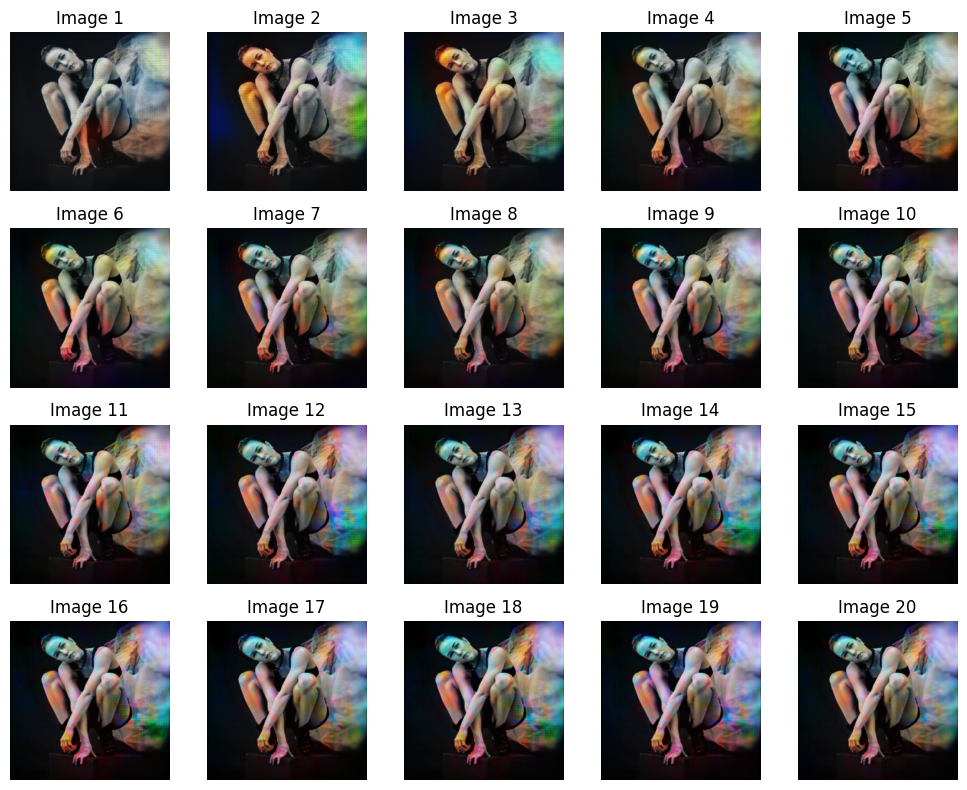

In [ ]:
making_multiplot('/content/_DSC121211.jpg')

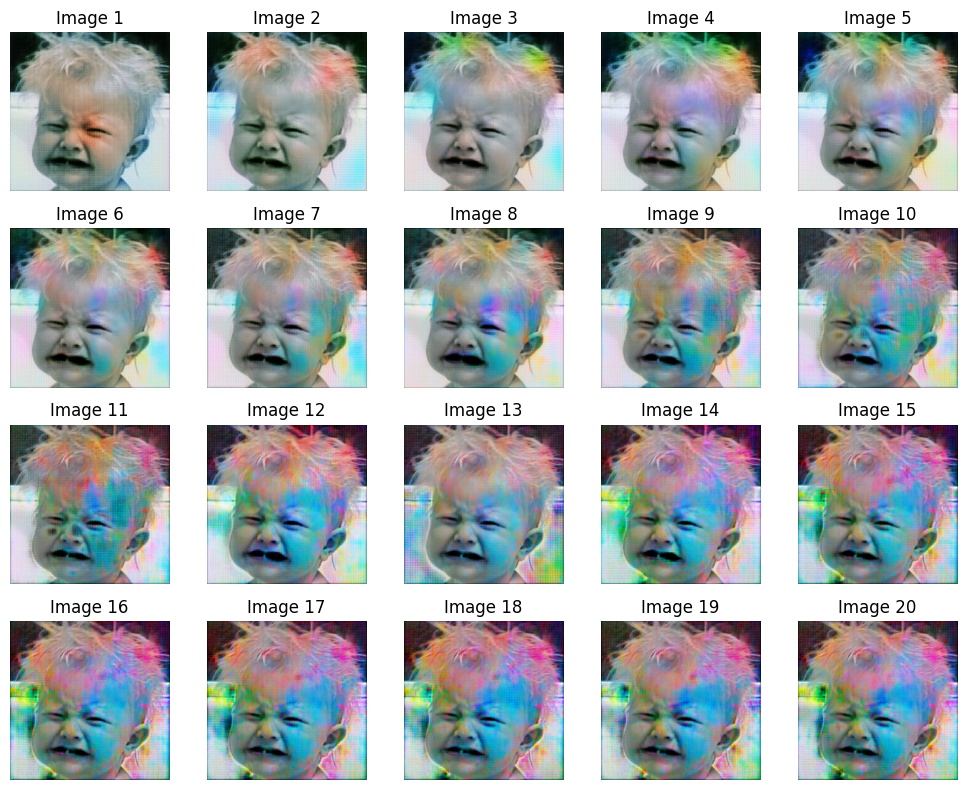

In [ ]:
making_multiplot('/content/drive/MyDrive/Colab_Notebooks/projects/Pix2Pix_GAN/test/DSCF6393 (2).JPG')